### This notebook is incomplete. It was originally in ct.split but moved out

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import seaborn as sns
import pickle as pkl
from functools import reduce

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
print(sc.__version__)
sc.settings.n_jobs=12

1.4.5.post1


In [3]:
prefix = '/data/codec/production.run/mrna/'

In [202]:
cts_markers = pd.read_csv('/data/codec/production.run/monaco2019.tableS2.fc_tpm.csv').set_index('Gene name').drop(columns=['Ensembl ID','Entrez ID'])

In [203]:
cts_markers = cts_markers.loc[np.intersect1d(cts_markers.index.values,concat['adata'].var_names.values)]

In [204]:
cts_markers.columns

Index(['Progenitors', 'B Naive', 'B NSM', 'B SM', 'B Ex', 'Plasmablasts',
       'T CD4 Naive', 'Tregs', 'Tfh', 'Th1', 'Th1/Th17', 'Th17', 'Th2',
       'T CD4 TE', 'T CD8 Naive', 'T CD8 CM', 'T CD8 EM', 'T CD8 TE',
       'T gd Vd2', 'T gd non-Vd2', 'MAIT', 'NK', 'pDCs', 'mDCs', 'Monocytes C',
       'Monocytes I', 'Monocytes NC', 'Neutrophils LD', 'Basophils LD',
       'B Naive+NSM', 'B Ex+SM', 'T CD4 Naive+Tregs', 'Tfh+Th1-17', 'Th',
       'T CD8 EM+TE', 'T gd', 'Monocytes NC+I', 'Granulocytes LD', 'B Memory',
       'Tfh+Th', 'T CD8 Memory', 'DCs', 'Monocytes C+I', 'B Naive+Memory',
       'T CD4 Memory', 'Monocytes', 'B cells', 'T CD4', 'T CD8', 'T Innate',
       'Myeloid Phagocytes', 'T Naive', 'T Memory', 'Phagocytes', 'APC',
       'T cells', 'Lymphoid', 'Myeloid', 'Adaptive', 'Innate'],
      dtype='object')

In [205]:
focus_cts = ['T cells', 'B cells', 'Myeloid']

In [206]:
cts_markers = cts_markers[focus_cts]

In [207]:
marker_genes = dict()

In [208]:
for ct in cts_markers.columns:
    s = cts_markers[ct].sort_values(ascending=False)
    marker_genes[ct] = s[s>3]

In [209]:
all_genes = reduce(np.append, map(lambda x: marker_genes[x].index.values, marker_genes.keys()))

In [210]:
v, c = np.unique(all_genes, return_counts=True)

In [211]:
remove_genes = v[c > 1]

In [212]:
new_marker_genes = dict()

In [213]:
for ct in marker_genes:
    current = marker_genes[ct].index.values
    unique_genes = np.setdiff1d(current, remove_genes)
    if len(unique_genes) != 0:
        new_marker_genes[ct] = marker_genes[ct].loc[unique_genes]

In [214]:
concat['adata'].obs.drop(columns=[i for i in concat['adata'].obs.columns if i.startswith('score_')], inplace=True)

In [215]:
for ct in tqdm(marker_genes):
    concat['adata'].obs['score_%s' % ct] = concat['adata'][:,marker_genes[ct].index].X.mean(1)

In [216]:
thresholds = [-0.15,0.03,0.22]

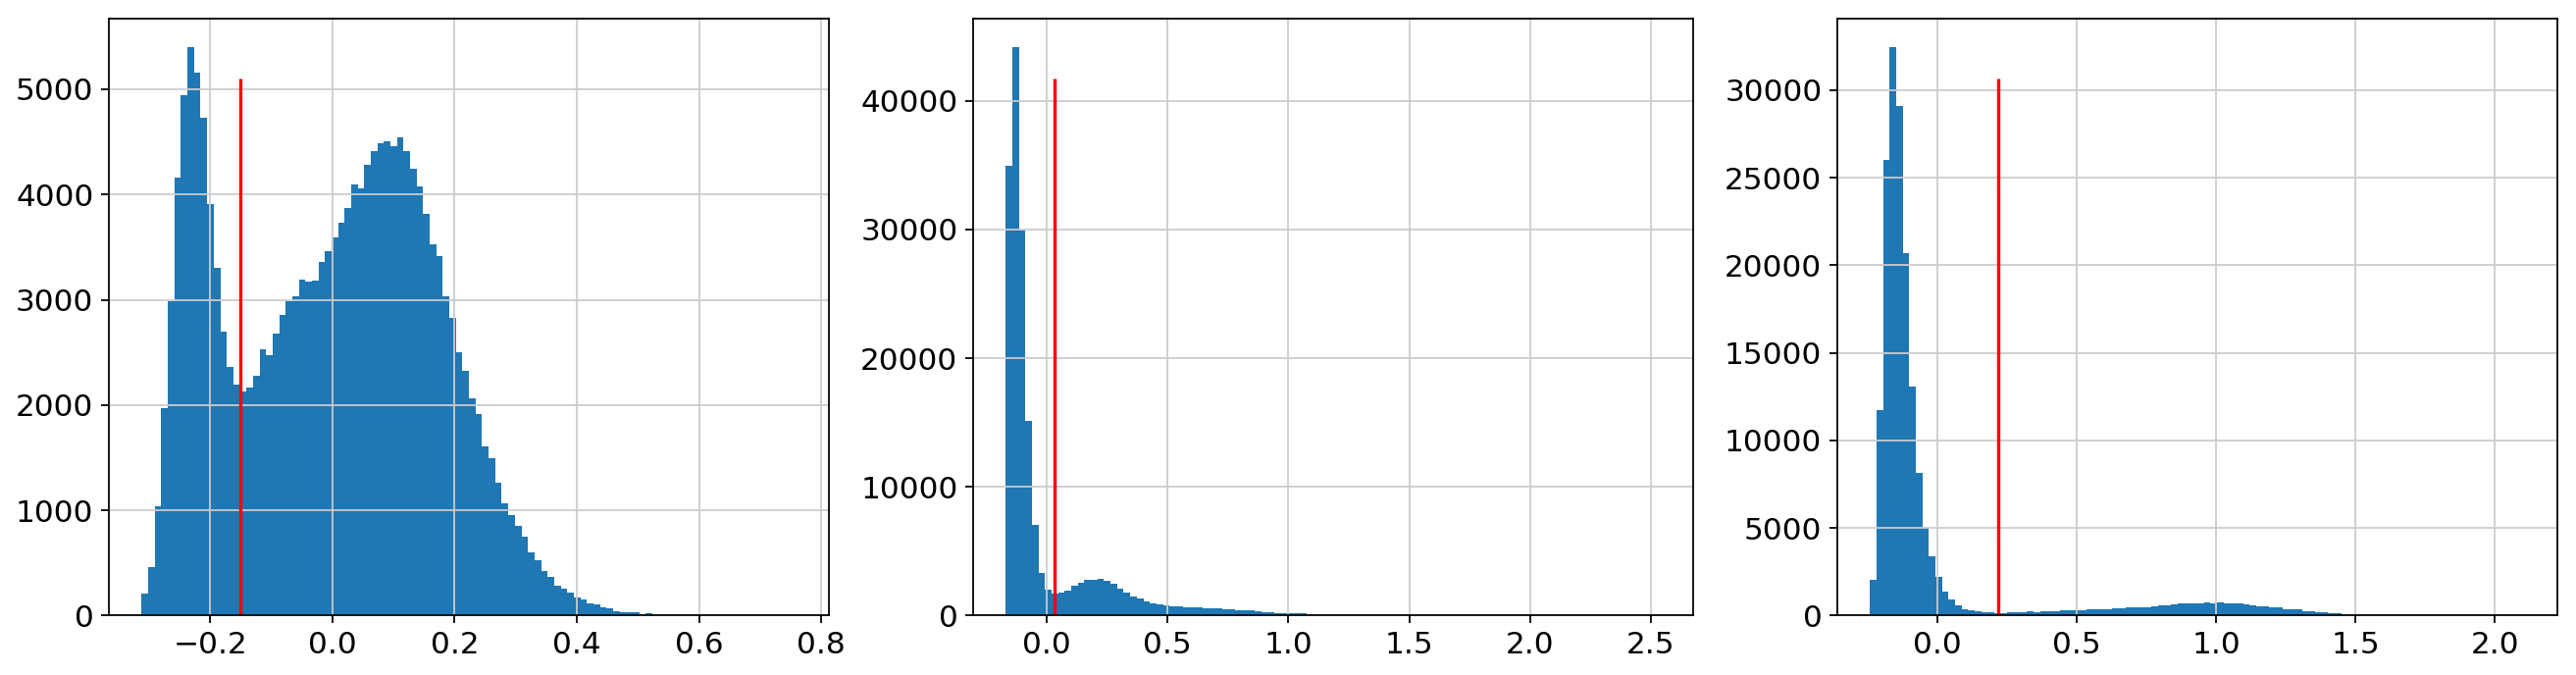

In [217]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
for ct, ax, t in zip(['T cells', 'B cells', 'Myeloid'], ax, thresholds):
    ax.hist(concat['adata'].obs['score_%s' % ct].values,bins=100);
    ax.vlines(t, 0, ax.set_ylim()[1]*0.9, color='r')

In [234]:
ct_thresh = dict(zip(focus_cts, thresholds))

In [245]:
ct_df = pd.DataFrame(index=focus_cts, 
                     columns=list(map(str,range(int(concat['adata'].obs['leiden'].dtype.categories[-1]) + 1)))
                    )

In [246]:
for c in tqdm(ct_df.columns):
    for i in ct_df.index:
        clust_cells = concat['adata'][concat['adata'].obs['leiden'] == c]
        scores = clust_cells.obs['score_%s' % i]
        pos_bool =  scores > ct_thresh[i]
        pos_mean = scores[pos_bool].mean()
        if pos_mean == np.nan:
            pos_mean
        ct_df.loc[i, c] = (pos_bool.sum()/len(pos_bool))*pos_mean

In [250]:
ct_df = ct_df.fillna(0).astype(np.float16, copy=False)

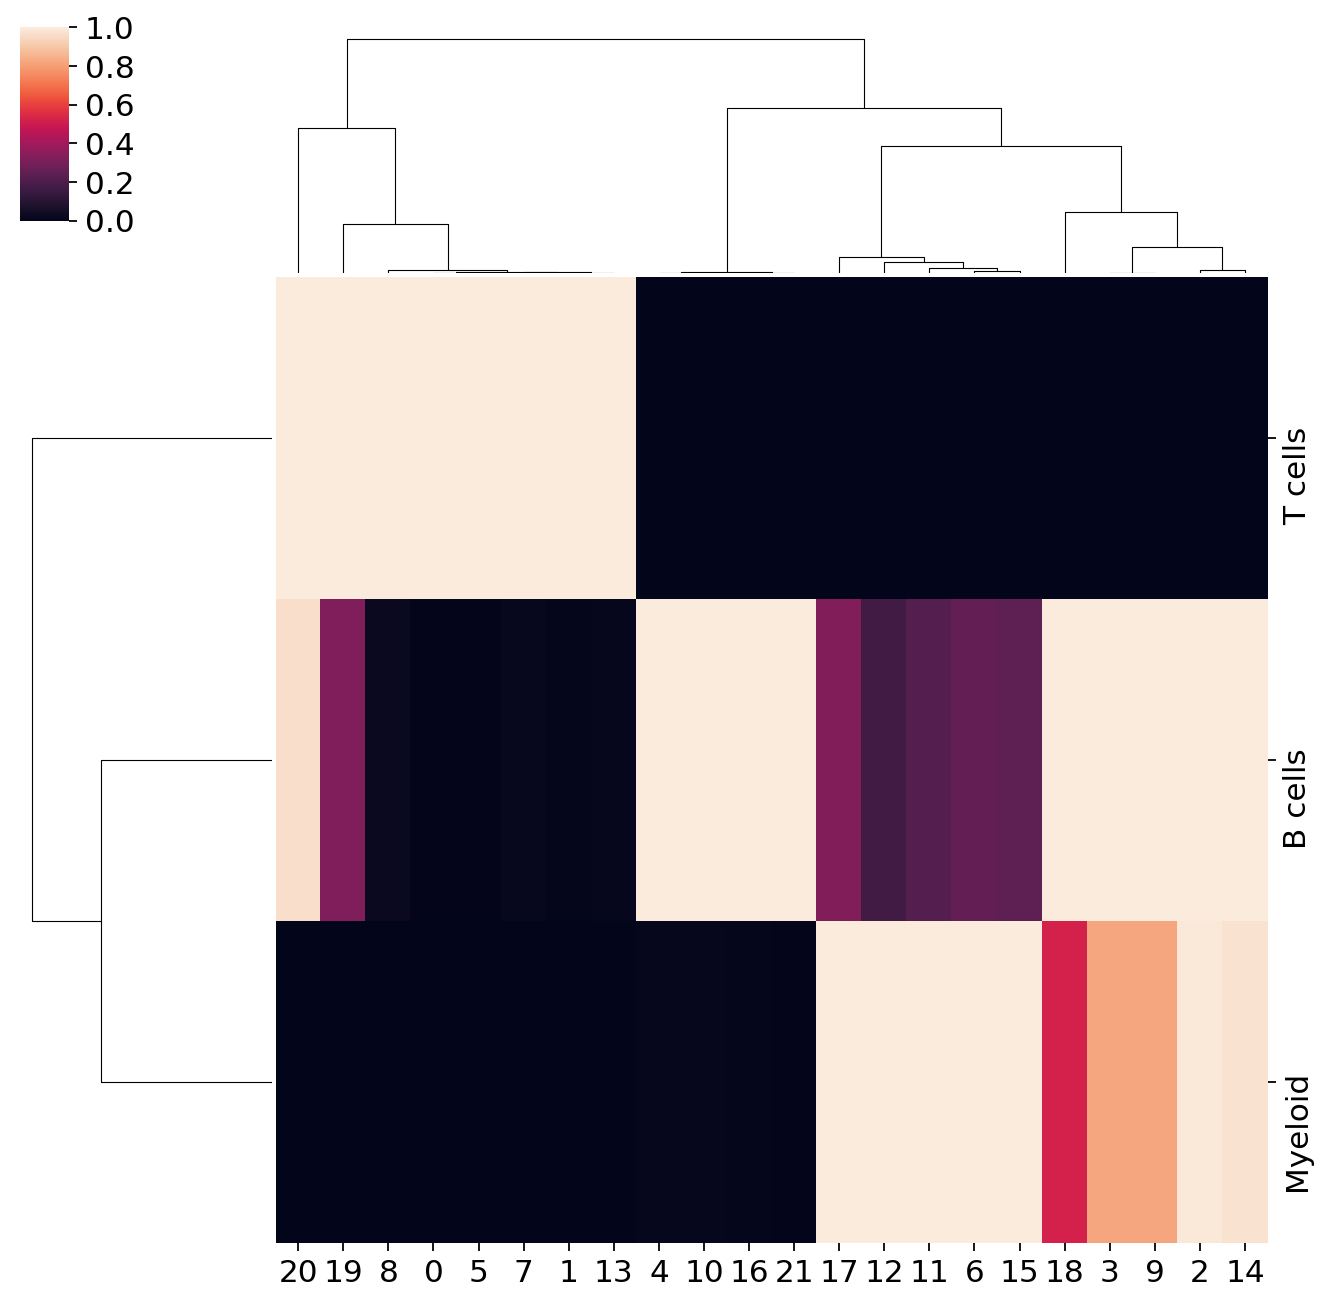

In [252]:
sns.clustermap(ct_df, standard_scale=1);